<a href="https://colab.research.google.com/github/AyozeGS/IABD/blob/main/7RO/T9/7RO_DQN_Cartpole_Tensorboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ayoze Gil Sosa

# Reinforcement Learning: Deep Q Learning: CartPole

Este actividad pretende explicar cómo funciona el aprendizaje por refuerzo combinado con el uso de una red neuronal. Esta técnica es conocida como DQN.

DQN utiliza redes neuronales para estimar los valores Q de un agente en un entorno. En lugar de mantener una tabla de valores Q para cada estado utiliza una red neuronal para aproximar estos valores a partir de los estados observados. Esto permite al agente aprender políticas óptimas en entornos complejos y continuos.

En el proceso de actualización de los valores Q en Deep Q Bellman no se utiliza directamente el propio valor Q(s, a).

La fórmula utilizada actualiza el valor Q(s, a) con la suma de la recompensa actual y el valor Q máximo predicho para el siguiente estado s', ponderado por  el factor de descuento.


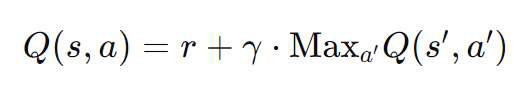




Utilizaremos el entorno CartPole-v0 en Gymnasium con el objetivo de equilibrar un poste aplicando fuerzas hacia la izquierda y la derecha sobre el carro. Tiene un espacio de acción discreto:

* 0: Empujar el carro hacia la izquierda
* 1: Empujar el carro hacia la derecha

Al tomar una acción, ya sea hacia la izquierda o hacia la derecha, un agente observa un estado de 4 dimensiones que consiste en:

* Posición del Carro
* Velocidad del Carro
* Ángulo del Poste
* Velocidad Angular del Poste

Se otorga una recompensa de al agente en cada paso mientras el poste se mantiene en posición vertical y se pierde si el Ángulo del Poste es mayor que ±12° o el Carro alcanza el borde de la pantalla.


En el proceso de actualización de los valores Q en Deep Q
Bellman, o sea en la fórmula para estimar el nuevo valor Q(s, a), no se utiliza directamente el propio valor Q(s, a).
La fórmula utilizada es:
Esta fórmula actualiza el valor Q(s, a) hacia el objetivo calculado, que es la suma


se organiza un agente de aprendizaje por refuerzo (DQN) y su interacción con un entorno utilizando la biblioteca Gym. La explicación detalla la inicialización, la recopilación de experiencias, la toma de decisiones (actuar), y el entrenamiento del modelo, junto con el almacenamiento de los resultados del aprendizaje.

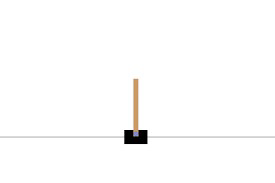

## Importa dependencias

In [ ]:
import numpy as np
import gym
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import os
from keras.callbacks import TensorBoard
import tensorflow as tf
import time

## Configuración de Parametros

Configuración para evitar el uso de GPU en TensorFlow/Keras

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "" #1

Inicialización del entorno de Gym con visualización

In [ ]:
env = gym.make('CartPole-v0', render_mode="human")

c:\Users\Ayo\anaconda3\envs\dqn\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [ ]:
state_size = env.observation_space.shape[0]
state_size

4

In [ ]:
action_size = env.action_space.n
action_size

2

In [ ]:
batch_size = 32
n_episodes = 500
output_dir = 'model_output/cartpole'

# Creación del directorio de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Directorio para los logs de TensorBoard

# Uso correcto de time.time() para obtener el tiempo actual en segundos
current_time = time.time()
log_dir = r'C:/Users/Ayo/Desktop/IABD/logs/dqn'
log_dir = os.path.join(log_dir, str(int(current_time)))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## Definición de la clase DQNAgent

In [ ]:
class DQNAgent():

    def __init__(self, state_size, action_size):

        # Inicializa el agente con sus parámetros y hiperparámetros.

        # Parámetros de estados y acciones para el input de la primera capa de la red neuronal
        self.state_size = state_size
        self.action_size = action_size

        # Instancia de una cola (deque) donde los elementos del principio serán automáticamente eliminados si se llena
        self.memory = deque(maxlen = 2000)

        # Factor de descuento
        self.gamma = 0.95

        # Parámetros Epsilon-greedy
        self.epsilon = 1.0 # Ratio inicial de exploración
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        # Tasa de aprendizaje que controla cuánto se actualiza el modelo en base al error.
        self.learning_rate = 0.001

        # Modelo construido a partir del método existente en el agente.
        self.model = self.build_model()

    # Construye y compila el modelo de red neuronal para deep Q learning
    def build_model(self):

        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation = 'relu')) # first hidden layer
        model.add(Dense(24, activation = 'relu')) # first hidden layer
        model.add(Dense(self.action_size, activation = 'linear')) # output layer
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = self.learning_rate))
        return model

    # Guarda en la memoria los parámetros propios de la ecuación de Bellman del aprendizaje por refuerzo.
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Realiza una acción de exploración o aleatoria en función del valor epsilon greedy.
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    # Entrena la red utilizando una minibatch de experiencias desde la memoria.
    def replay(self, batch_size):

        #Toma 16 muestras de la cola de memoria.
        minibatch = random.sample(self.memory, batch_size)

        # Se actualzia la matriz de recompensas y se entrena la red
        # utilizando las muestras de experiencia tomadas desde la cola
        for state, action, reward, next_state, done in minibatch:
            #Se actualiza la matriz de recomepnsas desde con la recompensa si se alcanza un estado final
            if done:
                target = reward
            # O se actualiza con la ecuación de Bellman
            else:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
                # target = R(s,a) + gamma * max Q`(s`,a`)
                # target (max Q` value) is output of Neural Network which takes s` as an input
                # amax(): flatten the lists (make them 1 list) and take max value
            train_target = self.model.predict(state, verbose=0) # s --> NN --> Q(s,a)=train_target
            train_target[0][action] = target
            # Se entrena el modelo y se guarda un histograma del mismo
            self.model.fit(state, train_target, epochs=1, callbacks=[tensorboard_callback], verbose = 0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # Carga los pesos del modelo desde un archivo
    def load(self, name):
        self.model.load_weights(name)

    # Guarda los pesos del modelo en un archivo
    def save(self, name):
        self.model.save_weights(name + ".weights.h5")

## Instanciación del agente

In [ ]:
agent = DQNAgent(state_size, action_size)

c:\Users\Ayo\anaconda3\envs\dqn\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Bucle principal de episodios para interacción con el entorno

In [ ]:
done = False
for e in range(n_episodes):

    # Se inicializa el entorno y se redimensiona el estado a la entrada de la red neuronal.
    state = env.reset()
    state = np.reshape(state[0], [1, state_size])
    total_reward = 0

    # Simulación por eposicio
    for utime in range(5000):

        env.render()

        # Se realiza una acción
        action = agent.act(state)

        # Se calculan los datos de la aplicar la acción
        next_state, reward, done, _, info  = env.step(action)
        total_reward += reward
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])

        # Se alamacenan los nuevos datos en la cola
        agent.remember(state, action, reward, next_state, done)

        # Se actualiza el estado
        state = next_state

        # Se se alcanza un estado final se muestran los resultados del episodio y se pasa al siguiente
        if done:
            # Se añaden valores para observar con tersorboard.
            with tf.summary.create_file_writer(log_dir).as_default():
                tf.summary.scalar('Total reward', total_reward, step=e)
                tf.summary.scalar('Epsilon', agent.epsilon, step=e)
                tf.summary.scalar('Memory', len(agent.memory), step=e)
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, n_episodes, utime, agent.epsilon))
            break

    # Si la memoria acumulada supera el tamaño de un lote se realiza un entrenamiento
    if len(agent.memory) > batch_size:
        agent.replay(batch_size) # memory is still not full

    # Guarda los pesos de la red neuronal del agente en un archivo cada 50 episodios
    if e % 50 == 0:
        agent.save(output_dir + "/weights_{:04d}".format(e))


episode: 0/500, score: 21, e: 1.0
episode: 1/500, score: 7, e: 1.0
episode: 2/500, score: 30, e: 0.99
episode: 3/500, score: 7, e: 0.99
episode: 4/500, score: 33, e: 0.99
episode: 5/500, score: 25, e: 0.98
episode: 6/500, score: 27, e: 0.98
episode: 7/500, score: 22, e: 0.97
episode: 8/500, score: 27, e: 0.97
episode: 9/500, score: 10, e: 0.96
episode: 10/500, score: 19, e: 0.96
episode: 11/500, score: 21, e: 0.95
episode: 12/500, score: 16, e: 0.95
episode: 13/500, score: 28, e: 0.94
episode: 14/500, score: 17, e: 0.94
episode: 15/500, score: 10, e: 0.93
episode: 16/500, score: 19, e: 0.93
episode: 17/500, score: 12, e: 0.92
episode: 18/500, score: 12, e: 0.92
episode: 19/500, score: 39, e: 0.91
episode: 20/500, score: 15, e: 0.91
episode: 21/500, score: 18, e: 0.9
episode: 22/500, score: 13, e: 0.9
episode: 23/500, score: 30, e: 0.9
episode: 24/500, score: 33, e: 0.89
episode: 25/500, score: 20, e: 0.89
episode: 26/500, score: 12, e: 0.88
episode: 27/500, score: 9, e: 0.88
episode: 2

Se observa que el aprendizaje es inestable, alcanzándose episodios con altas puntuaciones en episodios como los 357 a 360, pero no siendo capaz de mantener dichos puntuaciones. Se puede observar en los vídeos que se anexan.

En un enfoque DQN típico se utilizaría una segunda red llamada "red objetivo" para estabilizar los objetivos durante el aprendizaje. Esta red objetivo no se actualizaría en cada paso, sino a intervalos regulares.



## Gráficas TensorBoard

Utilizando la librería de Tensorboard podemos guardar logs durante el entrenamiento. Gracias a ello podemos ver como se han distribuido los pesos y los bias a lo largo del entrenamiento.

Desde la pestaña de distribución podemos observar la dispersión de los valores a medida que el modelo entrena, principalmenete en las primeras etapas del entrenamiento. En esta imagen:

* Existe un gráfica superpuesta por cada peso o bias.
* El eje x indican las horas de entrenamiento (algo menos de horas en total). Esta visualización se ha elegido eligiendo la opción "relative" en el menú lateral.
* El eje y indica el valor del bias o del peso respectivamente.


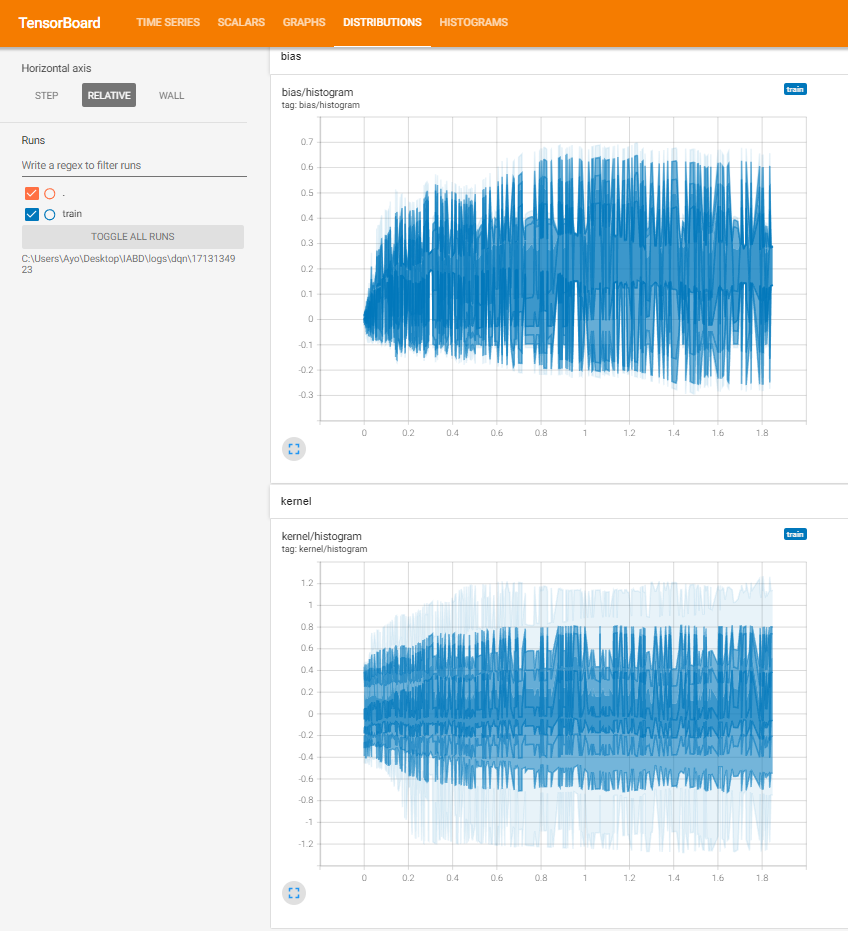

Estos valores tanto podemos verlos en forma de histograma, donde vemos como están distribuidos los valores del pesos o bias en cada momento.
En esta gráfica existen 3 ejes.

* El eje X indica los valores que alcanzan los pesos/bias.
* El eje y (altura de los gráficos) indica la cantidad (proporción) de bias/pesos para cada valor del eje x.
* El eje z observado de arrba(atrás) hacia abajo(delante) indica el tiempo relativo del entrenamiento.

De nuevo, vemos que existen varias formas de representar estas valores. A modo de ejemplo hemos seleccionado:
* El modo overlay, que muestra el porcentaje de distribución y solapa todas las gráficas sin usar relleno en ellas. No muestra valores en el eje z.
* El modo offset ,que rellena las imágenes y no muestra valores en el eje y,  combinado con el mode relativo, quer permite ver el eje z y aplica una perspectiva para no solapar demasiado las gráficas.


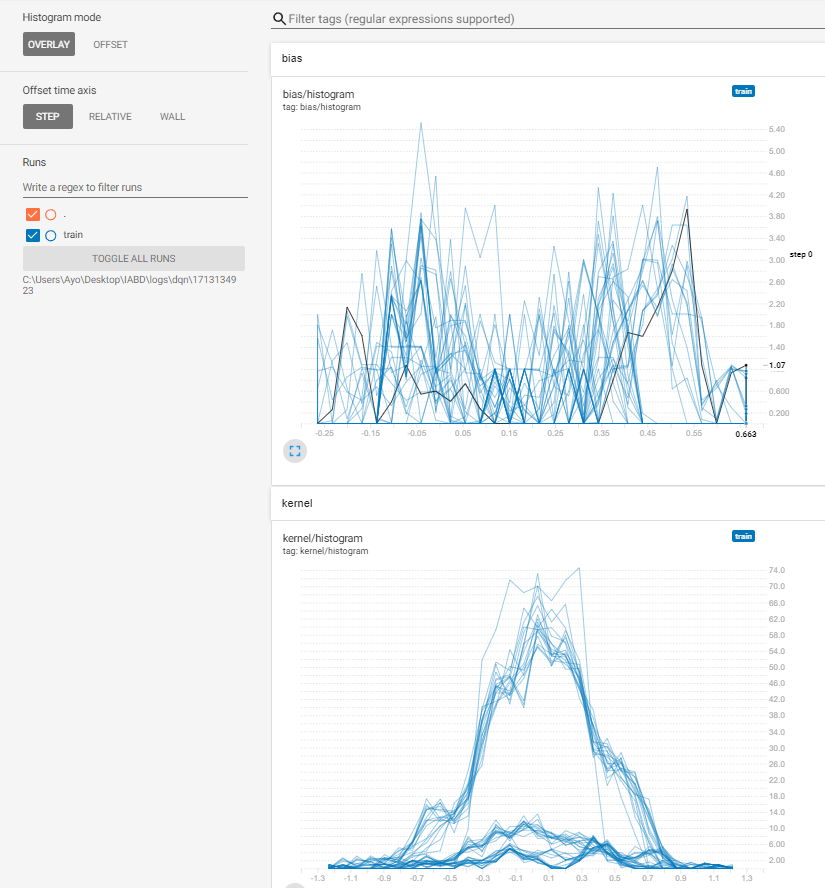

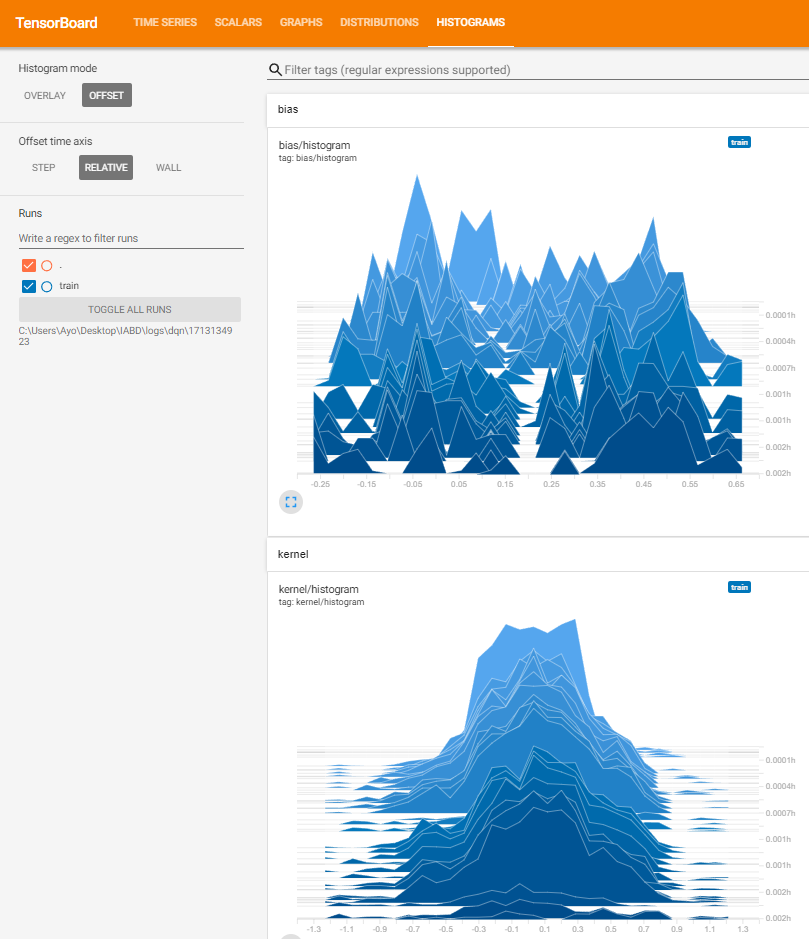

Auxiliarmente podemos guardar valores de variables que nos interese registrar, principalmente en el tiempo. Para esta actividad hemos visualizado 3 variables en concreto que pueden observarse en la pestaá de escalares o en la de series temporales:

* Epsilon-Greedy: sabemos que comienza en 1 y decae 0.005% por cada época.
* Memoria: El tamaño de la cola, que empieza en 0 y su máximo debe ser 2000.
* Un valor de recompensa total por cada episodio que debe mejorar si el modelo aprende.

Como se puede apreciar en las gráficas siguientes las primeras dos variables varán en el tiempo con se esperaba y la variable de recompensas nos permite apreciar como el modelo parece aprender aunque es algo inestable, no lo hace de forma progresiva y al final parece que empeiza a jugar peor, comportamiento que se observo con el primer entrenamiento de 1000 episodios.

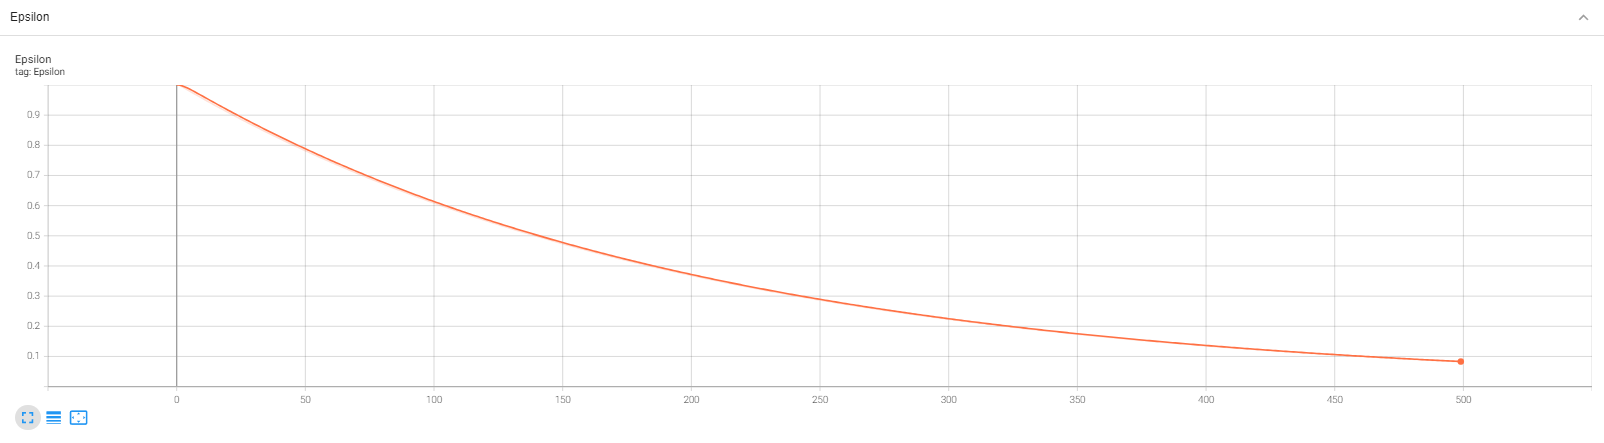

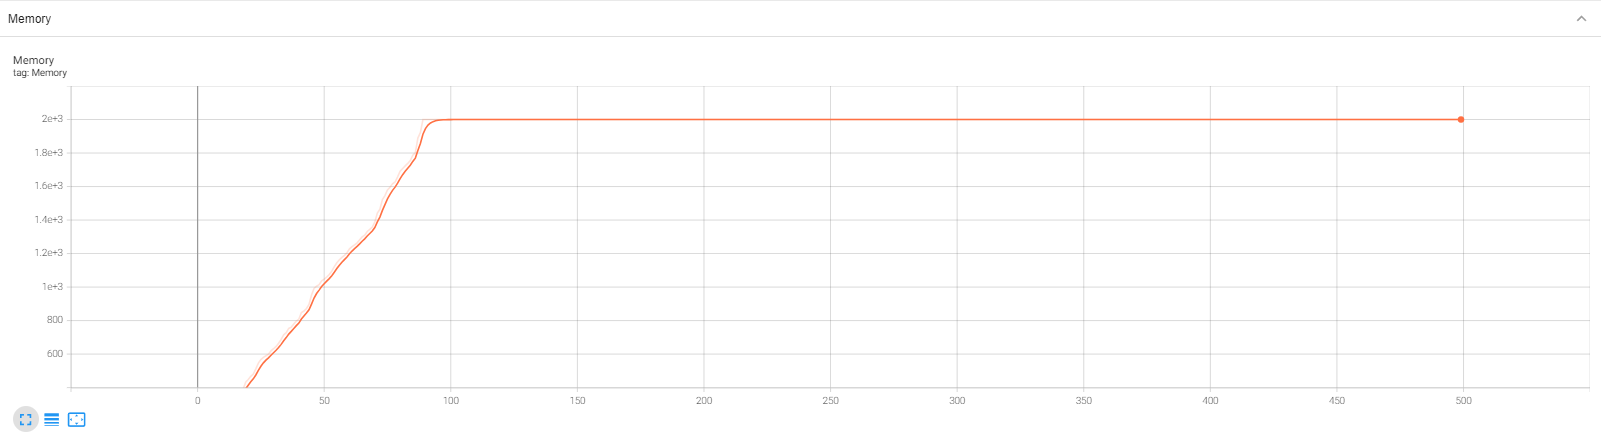

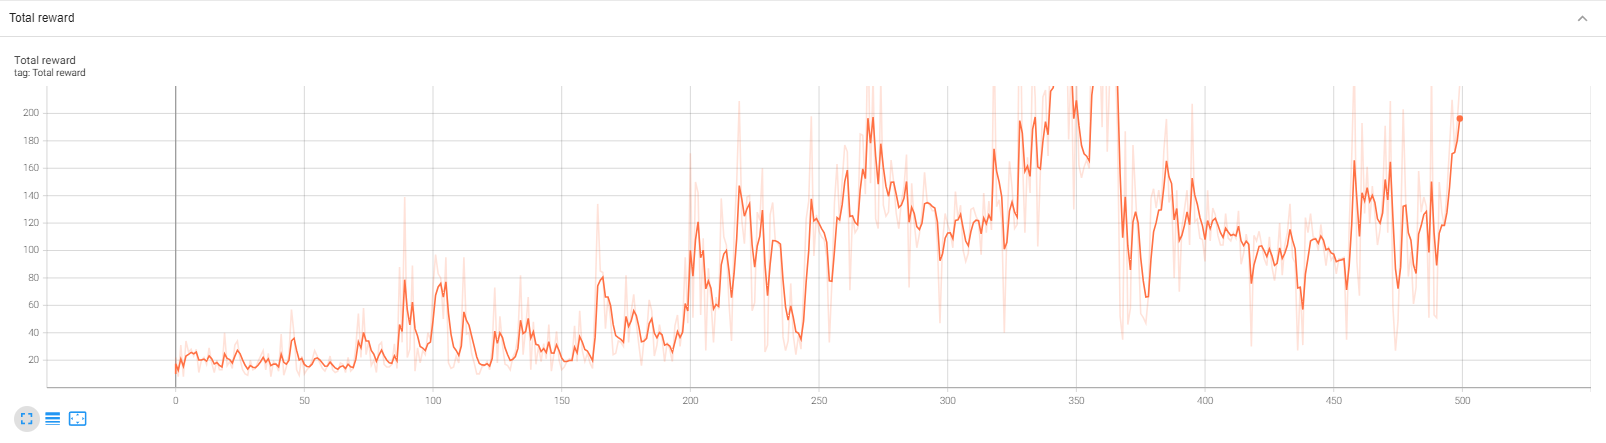

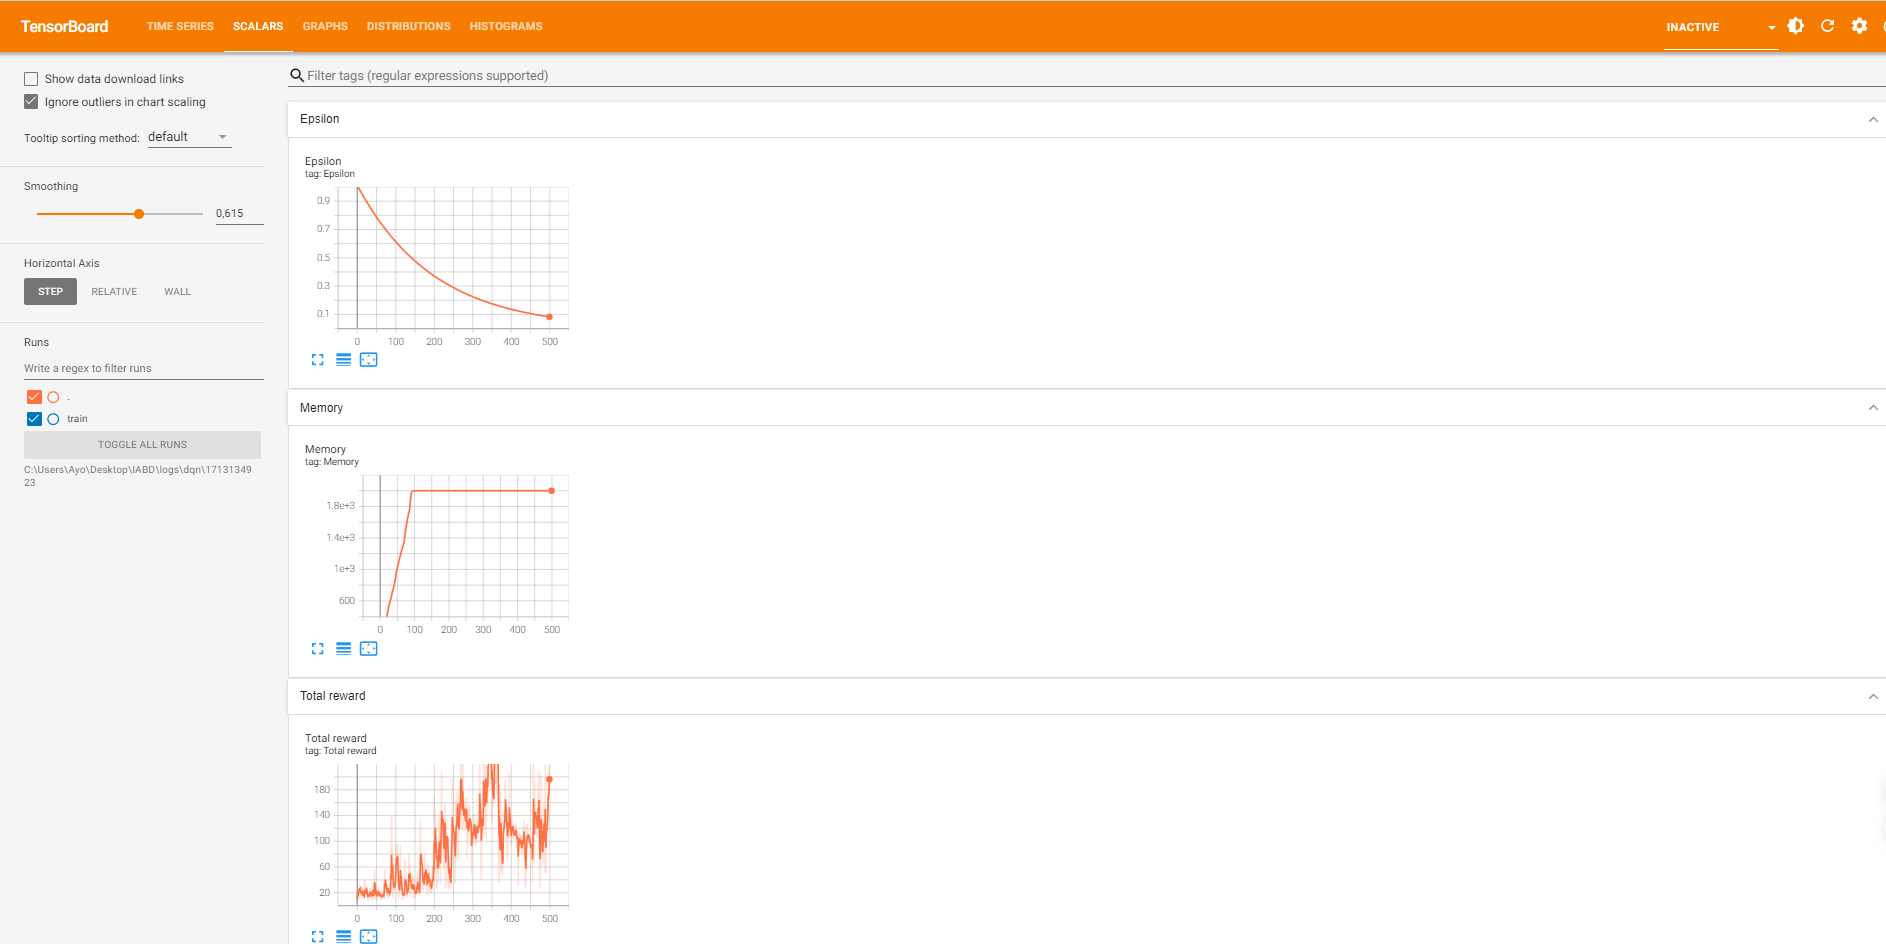